In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms, models
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
from PIL import Image
import os
from sklearn.metrics import jaccard_score as jsc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
main_dir = './drive/My Drive/hw5/training/image_2'
label_dir = './drive/My Drive/hw5/training/semantic'

# Loading pretrained model and its convolution layers
pretrained_model = models.vgg16(pretrained = True)
features = list(pretrained_model.features.children())
features[0].padding=(100,100)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [4]:
class FCN32(nn.Module):
    def __init__(self):
        super(FCN32,self).__init__()
        self.features_map=nn.Sequential(*features)
        self.conv=nn.Sequential(nn.Conv2d(512,4096,7),
                                nn.ReLU(inplace=True),
                                nn.Dropout(),
                                nn.Conv2d(4096,4096,1),
                                nn.ReLU(inplace=True),
                                nn.Dropout()
                                )
        self.score_fr=nn.Conv2d(4096,35,1)
        self.upscore=nn.ConvTranspose2d(35,35,64,32, bias = False)
        
    def forward(self,x):
        x_size=x.size()
        pool=self.conv(self.features_map(x))
        score_fr=self.score_fr(pool)
        upscore=self.upscore(score_fr)
        return upscore[:,:,19:(19+x_size[2]),19:(19+x_size[3])].contiguous()
        
        
        

In [5]:
class CustomDataset(Dataset):
    def __init__(self, main_dir, label_dir, transform):
        self.main_dir = main_dir
        self.label_dir = label_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        all_imgs_label = os.listdir(label_dir)
        self.total_imgs = natsorted(all_imgs)
        self.total_imgs_label = natsorted(all_imgs_label)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        img_loc_label = os.path.join(self.label_dir, self.total_imgs_label[idx] )
        image = Image.open(img_loc).convert('RGB')
        labels = Image.open(img_loc_label).convert('P')
        tensor_image = self.transform(image)
        tensor_label = self.transform(labels)
        return (tensor_image, (tensor_label*255).type(torch.LongTensor))

In [6]:
transform = transforms.Compose([transforms.Resize((256,1024)),
                                transforms.ToTensor()])


train_data = CustomDataset(main_dir, label_dir, transform)

length_train=int(0.7*len(train_data))
length_val= int(0.15*len(train_data))
length_test = len(train_data) - length_train - length_val

train, val, test = torch.utils.data.random_split(train_data, [length_train, length_val, length_test])


training_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
validation_loader = torch.utils.data.DataLoader(val, batch_size = 1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = False)

In [7]:
for image, labels in training_loader:
  print(image.size(), labels.size())
  break

torch.Size([1, 3, 256, 1024]) torch.Size([1, 1, 256, 1024])


In [8]:
model = FCN32().to(device)
model

FCN32(
  (features_map): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.99) # fine tuned the lr

In [10]:
epochs = 100
running_loss_history = []
val_running_loss_history = []

for e in range(epochs):
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labellist=torch.zeros(0,dtype=torch.long, device='cpu')

    predlist_val=torch.zeros(0,dtype=torch.long, device='cpu')
    labellist_val=torch.zeros(0,dtype=torch.long, device='cpu')
    running_loss = 0.0
    val_running_loss = 0.0
    
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels[:,0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _,preds = torch.max(outputs, dim = 1)
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        labellist=torch.cat([labellist,labels.view(-1).cpu()])

    

    else:
      with torch.no_grad(): # we do not need gradient for validation.
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels[:,0])
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()

          predlist_val=torch.cat([predlist_val,val_preds.view(-1).cpu()])
          labellist_val=torch.cat([labellist_val,val_labels.view(-1).cpu()])

    lbl = predlist.cpu().numpy().reshape(-1)
    target = labellist.cpu().numpy().reshape(-1)
    iou_micro = jsc(target, lbl, average = 'micro' )
    iou_macro = jsc(target, lbl, average = 'macro' )

    epoch_loss = running_loss/len(training_loader)
    running_loss_history.append(epoch_loss)
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)


    lbl_val = predlist_val.cpu().numpy().reshape(-1)
    target_val = labellist_val.cpu().numpy().reshape(-1)
    iou_val_micro = jsc(target_val, lbl_val, average = 'micro' )
    iou_val_macro = jsc(target_val, lbl_val, average = 'macro' )

    print('epoch :', (e+1))       
    print('training loss: {:.4f}, training iou(macro): {:.4f}, training iou(micro): {:.4f}'.format(epoch_loss, iou_macro, iou_micro))
    print('validation loss: {:.4f}, validation iou(macro): {:.4f}, validation iou(micro): {:.4f}'.format(val_epoch_loss, iou_val_macro, iou_val_micro))


epoch : 1
training loss: 3.5553, training iou(macro): 0.0067, training iou(micro): 0.0168
validation loss: 3.5551, validation iou(macro): 0.0078, validation iou(micro): 0.0213
epoch : 2
training loss: 3.5543, training iou(macro): 0.0104, training iou(micro): 0.0418
validation loss: 3.5524, validation iou(macro): 0.0138, validation iou(micro): 0.0822
epoch : 3
training loss: 3.0261, training iou(macro): 0.0162, training iou(micro): 0.1501
validation loss: 2.2632, validation iou(macro): 0.0207, validation iou(micro): 0.2200
epoch : 4
training loss: 1.9130, training iou(macro): 0.0285, training iou(micro): 0.2806
validation loss: 1.5767, validation iou(macro): 0.0489, validation iou(micro): 0.3562
epoch : 5
training loss: 1.5883, training iou(macro): 0.0473, training iou(micro): 0.3488
validation loss: 1.6028, validation iou(macro): 0.0529, validation iou(micro): 0.3555
epoch : 6
training loss: 1.4862, training iou(macro): 0.0531, training iou(micro): 0.3750
validation loss: 1.5472, valid

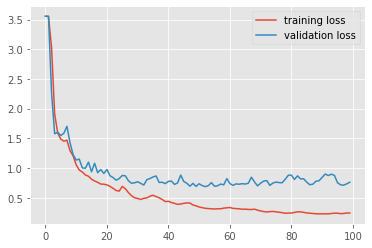

In [11]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [12]:
# Evaluating performance on test set
test_running_corrects = 0.0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
labellist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad(): # we do not need gradient for validation.
      for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        predlist=torch.cat([predlist,test_preds.view(-1).cpu()])
        labellist=torch.cat([labellist,test_labels.view(-1).cpu()])
        test_running_corrects += torch.sum(test_preds == test_labels[:,0].data)


test_acc = test_running_corrects.float()/ (len(test_loader)*1024*256)
print('test acc {:.4f} '.format(test_acc))

test acc 0.8302 


In [13]:
# Calculating mean IOU for test set
from sklearn.metrics import jaccard_score as jsc

lbl = predlist.cpu().numpy().reshape(-1)
target = labellist.cpu().numpy().reshape(-1)
print(jsc(target, lbl, average = 'micro' ))

0.709640729185145


In [131]:
final_data = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
test_running_corrects = 0.0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
labellist=torch.zeros(0,dtype=torch.long, device='cpu')
i = 0
index = 115
with torch.no_grad(): # we do not need gradient for validation.
      for test_inputs, test_labels in final_data:
        if i == index:
          test_inputs = test_inputs.to(device)
          test_labels = test_labels.to(device)
          test_outputs = model(test_inputs)
          _, test_preds = torch.max(test_outputs, 1)
          predlist=torch.cat([predlist,test_preds.view(-1).cpu()])
          labellist=torch.cat([labellist,test_labels.view(-1).cpu()])
          test_running_corrects += torch.sum(test_preds == test_labels[:,0].data)
          break
        else:
          i = i+1
        

test_acc = test_running_corrects.float()/(256*1024)
print('test acc {:.4f} '.format(test_acc))

test acc 0.8053 


In [132]:
# rename labels.py to id_labels
import id_labels

In [133]:
from collections import defaultdict
d = defaultdict(set)
L = id_labels.labels
for i in range(len(L)):
  d[L[i][1]] = L[i][-1]



In [137]:
predictions = test_preds.cpu().numpy()
predictions.shape

(1, 256, 1024)

In [138]:
lst = []
p = predictions[0,:]
for i in range(len(p)):
  for j in range(len(p[i])):
    lst.append((d[p[i][j]]))


In [139]:
arr = np.array(lst)

In [141]:
arr = np.reshape(arr,[256,1024,3])

In [144]:
g = np.zeros([256,1024,3])
for i in range(len(arr)):
  for j in range(len(arr[i])):
    for k in range(len(arr[i][j])):
      g[i][j][k] = arr[i][j][k]/255.0

In [146]:
import cv2
cv2.imwrite('color_img.jpg',arr)
c = cv2.imread('color_img.jpg', 1)
c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
cv2.imwrite('Final_img.jpg', c)

True

In [49]:
torch.save(model, "./drive/My Drive/hw5/entire_model_fcn32_final.pt")

In [50]:
model = torch.load('./drive/My Drive/hw5/entire_model_fcn32_final.pt')

In [ ]:
model.eval()